In [ ]:
!pip install deepxde

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 192.3/192.3 kB 8.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.8/107.8 kB 10.3 MB/s eta 0:00:00


In [ ]:
import deepxde as dde
from deepxde.backend import tf

No backend selected.
Finding available backend...


Using backend: tensorflow.compat.v1
Other supported backends: tensorflow, pytorch, jax, paddle.
paddle supports more examples now and is recommended.
Instructions for updating:
non-resource variables are not supported in the long term


Found tensorflow.compat.v1
Setting the default backend to "tensorflow.compat.v1". You can change it in the ~/.deepxde/config.json file or export the DDE_BACKEND environment variable. Valid options are: tensorflow.compat.v1, tensorflow, pytorch, jax, paddle (all lowercase)


Enable just-in-time compilation with XLA.



In [ ]:
!pip install -U pysr

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.6/54.6 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 93.9/93.9 kB 5.6 MB/s eta 0:00:00


In [ ]:
!pip install -U juliacall pysr

Compiling model...
Building feed-forward neural network...
'build' took 0.187406 s

'compile' took 12.693956 s

Training model...

Step      Train loss                        Test loss                         Test metric
0         [1.98e-01, 8.85e-01, 2.02e-02]    [2.17e-01, 8.85e-01, 2.02e-02]    []  
400       [5.28e-05, 7.87e-05, 1.55e-02]    [5.66e-05, 7.87e-05, 1.55e-02]    []  
800       [1.94e-05, 4.86e-05, 1.55e-02]    [1.93e-05, 4.86e-05, 1.55e-02]    []  
1200      [1.34e-05, 3.57e-05, 1.55e-02]    [1.09e-05, 3.57e-05, 1.55e-02]    []  
1600      [1.32e-05, 3.04e-05, 1.55e-02]    [9.38e-06, 3.04e-05, 1.55e-02]    []  
2000      [1.25e-05, 2.88e-05, 1.55e-02]    [8.47e-06, 2.88e-05, 1.55e-02]    []  
2400      [1.05e-05, 2.88e-05, 1.55e-02]    [6.74e-06, 2.88e-05, 1.55e-02]    []  
2800      [7.67e-06, 3.30e-05, 1.54e-02]    [4.79e-06, 3.30e-05, 1.54e-02]    []  
3200      [6.85e-06, 5.35e-05, 1.53e-02]    [4.53e-06, 5.35e-05, 1.53e-02]    []  
3600      [9.23e-06, 6.75e-05, 1

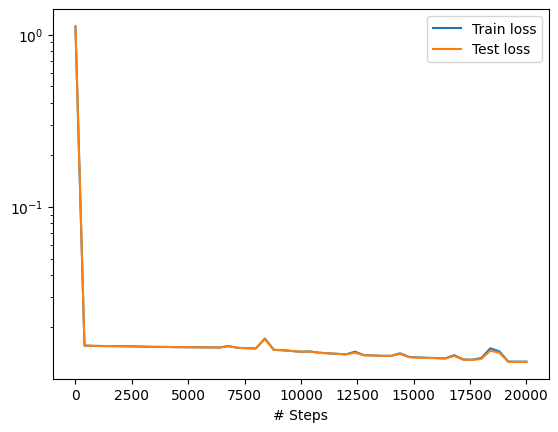

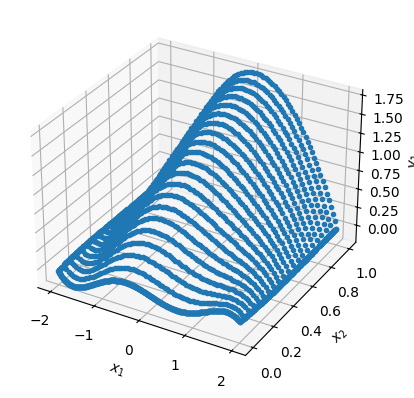

In [ ]:

import numpy as np
import pandas as pd
#%matplotlib inline
import matplotlib.pyplot as plt
import random
import deepxde as dde
import numpy as np
import deepxde as dde
from matplotlib import pyplot as plt
import numpy as np
import skopt
from skopt import gp_minimize
from skopt.plots import plot_convergence, plot_objective
from skopt.space import Real, Categorical, Integer
from skopt.utils import use_named_args

if dde.backend.backend_name == "pytorch":
    sin = dde.backend.pytorch.sin
else:
    from deepxde.backend import tf

    sin = tf.sin


# Clear TensorFlow session
tf.keras.backend.clear_session()
M = 0.2
# General parameters
epochs = 20000

def pde(x, y):
     dy_x = dde.grad.jacobian(y, x, i=0, j=0)
     dy_t = dde.grad.jacobian(y, x, i=0, j=1)
     dy_xx = dde.grad.hessian(y, x, i=0, j=0)
     dy_xxx = dde.grad.hessian(dy_x, x, i=0, j=0)
     #dy_xxxx = dde.grad.hessian(dy_xx, x, i=0, j=0)
     dy_xxxxx = dde.grad.hessian(dy_xxx, x, i=0, j=0)

     #dy_t + y * dy_x - 0.5*dy_xx -(M*0.5) * y
     #dy_t + y * dy_x + 0.5*dy_xxx -(M*0.5) * y
     #dy_t + y * dy_x + 0.5*dy_xxxx -(M*0.5) * y
     #dy_t + y * dy_x + 0.5*dy_xxx + 0.5*dy_xxxxx-(M*0.5) * y

     return dy_t + y * dy_x + 0.5*dy_xxx + 0.5*dy_xxxxx-(M*0.5) * y

#geom = dde.geometry.Polygon([[0, 0], [1, 0], [1, -1], [-1, -1], [-1, 1], [0, 1]])
geom = dde.geometry.Interval(-2, 2)
timedomain = dde.geometry.TimeDomain(0, 1)
geomtime = dde.geometry.GeometryXTime(geom, timedomain)

bc = dde.DirichletBC(geomtime, lambda x: 0, lambda _, on_boundary: on_boundary)
ic = dde.IC(geomtime, lambda x: -np.sin(np.pi * x[:, 0:1]), lambda _, on_initial: on_initial)
#data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=1000,  num_boundary=150, num_initial=100,num_test=1296)
data = dde.data.TimePDE(geomtime, pde, [bc, ic], num_domain=2500, num_boundary=700, num_initial=600,num_test=1500 )
# The last one is final for our paper

# [0.00014162001602662018, 4, 16, 'sin', lamda=0.03110204078235363]
lamda=0.03110

net = dde.nn.FNN([2] + [30] * 5 + [1], "sin", "Glorot normal")
model1 = dde.Model(data, net)
model1.compile("adam", lr=1.0e-3, loss_weights=(1, 1, lamda))
losshistory, train_state =model1.train(iterations=epochs,display_every=400)
dde.saveplot(losshistory, train_state, issave=True, isplot=True)


In [1]:
import matplotlib as mpl
import matplotlib.pyplot as plt
#mpl.use('pgf')
import tensorflow as tf
import numpy as np
import scipy.io
from scipy.interpolate import griddata
import time
from itertools import product, combinations
from mpl_toolkits.mplot3d import Axes3D
from mpl_toolkits.mplot3d.art3d import Poly3DCollection
#from plotting import newfig, savefig
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.gridspec as gridspec

In [ ]:
tps = 201
t=np.linspace(0,1,tps).reshape(-1,1)
x=np.linspace(-2,2,tps).reshape(-1,1)
xx, tt = np.meshgrid(x, t)
X = np.vstack((np.ravel(xx), np.ravel(tt))).T

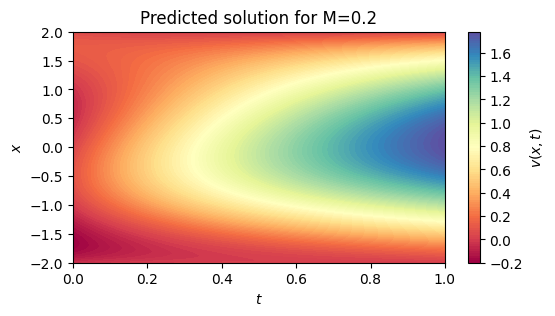

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Generate time (t) and space (x) grids
#t = np.linspace(0, 1, 101).reshape(-1, 1)  # 101 evenly spaced points between 0 and 2
#x = np.linspace(-1, 1, 101).reshape(-1, 1)  # 101 evenly spaced points between -1 and 1

# Create 2D grids (xx and tt) from 1D x and t arrays
#xx, tt = np.meshgrid(x, t)

# Stack the xx and tt grids to form the input data matrix X
#X = np.vstack((np.ravel(xx), np.ravel(tt))).T


# Predict the solution using the current model
y_pred = model1.predict(X)

# Reshape the predicted solution into the 2D domain
U_pred = y_pred.flatten().reshape(tps, tps)

# Visualize results for each M
plt.figure(figsize=(6, 3))
plt.contourf(tt, xx, U_pred, 100, cmap="Spectral")
plt.title(f"Predicted solution for M={M}")
plt.colorbar(label="$v(x,t)$")
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.show()


In [ ]:
# Generating time (t) and space (x) grids
#t=np.linspace(0,1,101).reshape(-1,1) # 101 evenly spaced points between 0 and 1, reshaped to a column vector
#x=np.linspace(-2,2,101).reshape(-1,1)# 101 evenly spaced points between 0 and 10, reshaped to a column vector
# Creating 2D grids (xx and tt) from 1D x and t arrays
#xx, tt = np.meshgrid(x, t)
# Stacking the xx and tt grids to form the input data matrix X
#X = np.vstack((np.ravel(xx), np.ravel(tt))).T

# Predicting ts[0].predict(X)
# Predicting the residual using the trained model
f = model1.predict(X, operator=pde)
print("Mean residual:", np.mean(np.absolute(f)))
#U_pred =y_pred.flatten().reshape(101,101) # Predicted solution Over the 2D domain

Mean residual: 0.0068351445


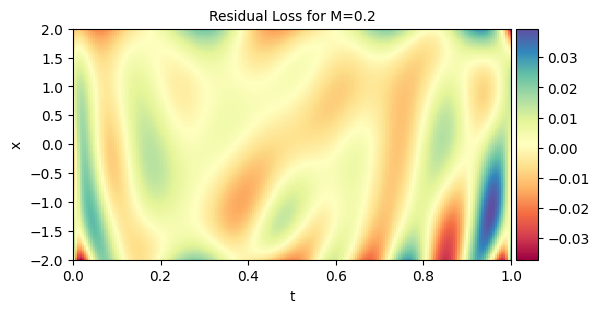

In [ ]:
fig, ax = plt.subplots(figsize=(6, 3))

# Plot the 2D image of the residual using imshow
h = ax.imshow(f.reshape(tps, tps), interpolation='nearest', cmap='Spectral',
              extent=[t.min(), t.max(), x.min(), x.max()],
              origin='lower', aspect='auto')

# Add a colorbar for the image
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.05)
fig.colorbar(h, cax=cax)

# Set the labels, title, and legend for the plot
ax.set_xlabel('t')
ax.set_ylabel('x')
ax.set_title(f"Residual Loss for M={M}", fontsize=10)

# Save the plot as 'u_residual.eps' with dpi (dots per inch) set to 100
plt.savefig('Residual_comb.eps', dpi=300)

Computed indices: [0, 100, 160, 200]


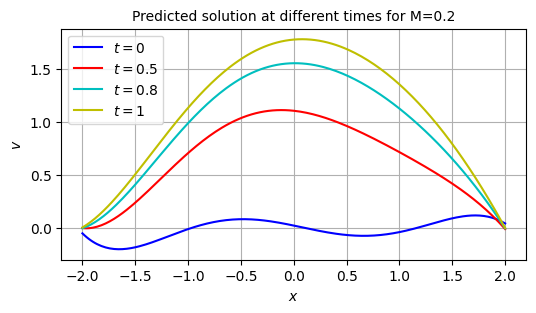

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters for time discretization
T = 1.0   # Total time
N_t = 201  # Number of time steps
delta_t = T / (N_t - 1)

# Time points of interest
time_points = [0, 0.5, 0.8, 1]

# Compute indices
indices = [round(t / delta_t) for t in time_points]
print("Computed indices:", indices)


# Create the figure and axis
fig, ax = plt.subplots(figsize=(6, 3))

# Colors for each time slice
colors = ['b-', 'r-', 'c-', 'y-']

# Plotting invisible lines with labels for legend
for t, color in zip(time_points, colors):
    ax.plot([], [], color, label=f'$t = {t}$')

# Plotting the function slices at specified time points
for idx, color in zip(indices, colors):
    ax.plot(x, U_pred[idx, :], color)

# Adding labels and title
ax.set_xlabel('$x$')
ax.set_ylabel('$v$')
ax.legend()

# Set the title
ax.set_title(f"Predicted solution at different times for M={M}", fontsize=10)

# Save the figure
plt.savefig('w_slice_comb.eps', dpi=300, bbox_inches='tight')

# Display the plot
plt.grid()
plt.show()


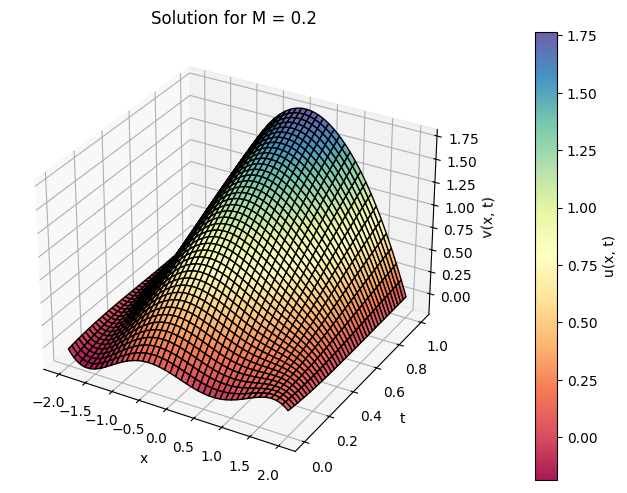

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assuming x, t, and U_pred are defined

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(
        xx, tt, U_pred, cmap="Spectral", edgecolor="k", alpha=0.9
    )

# Add color bar
cbar = fig.colorbar(surf, ax=ax, pad=0.1)
cbar.set_label("u(x, t)")

# Customize the plot
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("v(x, t)")
ax.set_title(f"Solution for M = {M}")
#ax.view_init(10, 290)  # Set the viewing angle for better 3D perspective

plt.tight_layout()
plt.show()

In [ ]:
import pandas as pd

# Assuming you have already computed U_pred
data0 = {'x': xx.flatten(), 't': tt.flatten(), 'type': [0] * len(xx.flatten()),'y_pred': U_pred.flatten()}
df0 = pd.DataFrame(data0)

In [ ]:
X = df0[['t','x']].values
y = df0['y_pred'].values

In [ ]:
df0

,x,t,type,y_pred
0,-2.00,0.0,0,-0.047533
1,-1.98,0.0,0,-0.066314
2,-1.96,0.0,0,-0.083598
3,-1.94,0.0,0,-0.099437
4,-1.92,0.0,0,-0.113881
...,...,...,...,...
40396,1.92,1.0,0,0.145016
40397,1.94,1.0,0,0.110118
40398,1.96,1.0,0,0.074857
40399,1.98,1.0,0,0.039233


In [ ]:
import pysr
import sympy
import numpy as np
from matplotlib import pyplot as plt
from pysr import PySRRegressor
from sklearn.model_selection import train_test_split

# Extract features and target variable
X_raw = df0[['x', 't']].values
y = df0['y_pred'].values

# Fit the PySR model
model = PySRRegressor(
    niterations=34,
    batching=True,
    batch_size=264,
    fast_cycle=True,
    binary_operators=["+", "*", "-", "/"],
    unary_operators=["exp", "sin", "cos"],
    populations=30,
    model_selection='best',
    #maxsize=30,
)
model.fit(X_raw, y)

/usr/local/lib/python3.11/dist-packages/pysr/sr.py:2774: UserWarning: Note: it looks like you are running in Jupyter. The progress bar will be turned off.
  warnings.warn(
[ Info: Started!



Expressions evaluated per second: 9.900e+02
Progress: 98 / 1020 total iterations (9.608%)
════════════════════════════════════════════════════════════════════════════════════════════════════
───────────────────────────────────────────────────────────────────────────────────────────────────
Complexity  Loss       Score      Equation
1           2.504e-01  1.594e+01  y = 0.61718
2           1.735e-01  3.669e-01  y = sin(x₁)
3           1.441e-01  1.854e-01  y = x₁ * 1.2046
4           1.419e-01  1.583e-02  y = cos(x₀ / 1.3269)
5           1.018e-01  3.319e-01  y = exp(cos(x₀)) * x₁
6           2.139e-02  1.560e+00  y = x₁ * (cos(x₀) + 0.82195)
8           8.180e-03  4.807e-01  y = cos(x₀ / -1.2369) * (x₁ / 0.51138)
9           5.380e-03  4.189e-01  y = ((cos(x₀) + 0.38851) * sin(x₁)) * 1.5945
28          4.184e-03  1.324e-02  y = exp(-0.80382 / ((((exp(cos((exp(-0.6494 - x₁) + x₀) - ...
                                      0.32154) * exp(x₁)) * x₁) / 1.027) + 0.22744) / (x₁ + 1.24...
 

[ Info: Final population:
[ Info: Results saved to:


PySRRegressor.equations_ = [
	    pick     score                                           equation  \
	0         0.000000                                         0.61718345   
	1         0.366925                                            sin(x1)   
	2         0.185373                                     x1 * 1.2045729   
	3         0.044024                               cos(x0 / -1.2246752)   
	4         0.736301                                  x1 / cos(cos(x0))   
	5         1.198077                        (cos(x0) + 0.75537187) * x1   
	6         0.434117                  x1 * (exp(cos(x0)) + -0.51473725)   
	7         0.487937           x1 * ((cos(x0) + 0.4004518) * 1.4168708)   
	8         0.389851     sin(x1) * ((cos(x0) + 0.39421082) * 1.5816278)   
	9         0.052722  sin(sin(x1)) * ((cos(x0) + 0.3972658) * 1.7022...   
	10        0.458768  ((cos(0.07257407 - x0) + 0.39730865) * sin(x1)...   
	11        0.083621  (cos(x0 - 0.07187301) + 0.39218977) * (1.71637...   
	12        0.014570  (sin(sin(x1)) * ((cos(0.075547226 - x0) + 0.41...   
	13        0.037233  (sin(sin(x1 - (x0 * 0.025862452))) * 1.72825) ...   
	14        0.094644  (0.39346814 + cos(0.10007442 - x0)) * (1.71559...   
	15        0.040741  ((0.39346814 + cos(0.10007442 - x0)) * 1.71559...   
	16        0.336173  ((sin(sin(x1)) * 1.7268893) - (sin(x0 * 2.6842...   
	17        0.075338  ((cos(x0 - 0.067563735) + 0.38346153) * 1.5976...   
	18        0.194517  (sin(sin((x1 - (x0 * -0.28246543)) - (sin(x0) ...   
	19        0.065972  sin(sin((x1 - (x0 * -0.345072)) - sin(sin(x0) ...   
	20        0.005408  ((cos(0.06929245 - x0) + 0.3883469) * sin(sin(...   
	21        0.005888  (cos(0.06526294 - x0) + 0.38644817) * (sin(sin...   
	22  >>>>  0.294354  ((cos(0.06555329 - x0) + 0.41444486) * 1.69836...   
	
	        loss  complexity  
	0   0.250383           1  
	1   0.173481           2  
	2   0.144127           3  
	3   0.137919           4  
	4   0.066047           5  
	5   0.019931           6  
	6   0.012912           7  
	7   0.007927           8  
	8   0.005368           9  
	9   0.005092          10  
	10  0.003218          11  
	11  0.002960          12  
	12  0.002875          14  
	13  0.002669          16  
	14  0.002428          17  
	15  0.002331          18  
	16  0.001665          19  
	17  0.001545          20  
	18  0.001272          21  
	19  0.001190          22  
	20  0.001184          23  
	21  0.001163          26  
	22  0.000867          27  
]

  - outputs/20250317_164150_w2iK1m/hall_of_fame.csv


In [ ]:
print(model.sympy())

(cos(0.06555329 - x0) + 0.41444486)*1.6983646*sin(sin(-(-0.07595206)*x0 + x1 - 0.17622922*(x0 - 1*0.05411254)*cos(0.1773623 - x0)))


In [ ]:
print(model.latex())

\left(\cos{\left(0.0656 - x_{0} \right)} + 0.414\right) 1.70 \sin{\left(\sin{\left(- \left(-0.0760\right) x_{0} + x_{1} - \cos{\left(0.177 - x_{0} \right)} \left(x_{0} - 0.0541\right) 0.176 \right)} \right)}


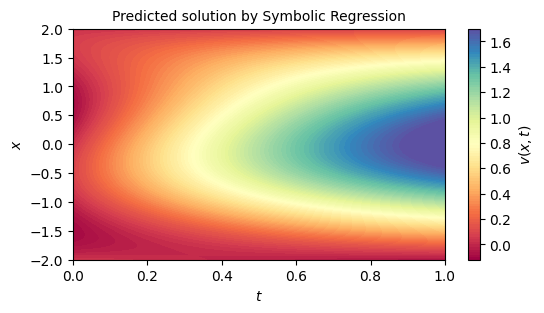

In [2]:
t=np.linspace(0,1,201).reshape(-1,1)
x=np.linspace(-2,2,201).reshape(-1,1)
xx, tt = np.meshgrid(x, t)
X = np.vstack((np.ravel(xx), np.ravel(tt))).T


def my_function(x0, x1):
    term1 =(np.cos(0.06555329 - x0) + 0.41444486)*1.6983646*np.sin(np.sin(-(-0.07595206)*x0 + x1 - 0.17622922*(x0 - 1*0.05411254)*np.cos(0.1773623 - x0)))
    return (term1)

U_SymReg = my_function(xx, tt)
vmin, vmax = -0.2, 1.7
U_clamped = np.clip(U_SymReg, vmin, vmax)

plt.figure(figsize=(6, 3))
contour= plt.contourf(tt, xx, U_clamped, 100, cmap="Spectral")
plt.colorbar(contour, label="$v(x,t)$")
plt.xlabel("$t$")
plt.ylabel("$x$")
plt.title('Predicted solution by Symbolic Regression', fontsize = 10)
plt.show()


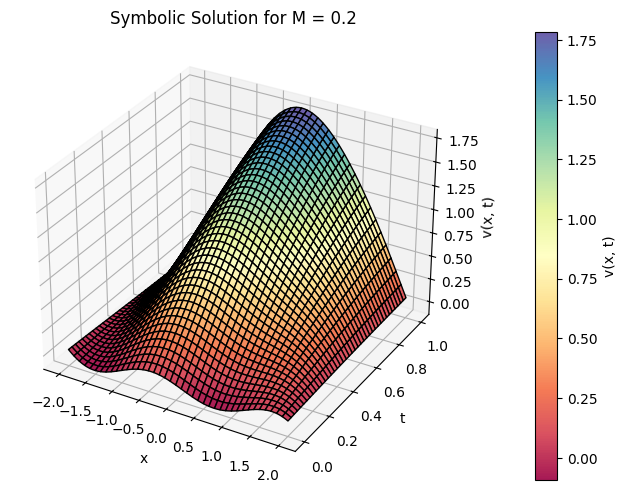

In [ ]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Assuming x, t, and U_pred are defined

fig = plt.figure(figsize=(8, 5))
ax = fig.add_subplot(111, projection='3d')

# Plot the surface
surf = ax.plot_surface(
        xx, tt, U_SymReg, cmap="Spectral", edgecolor="k", alpha=0.9
    )

# Add color bar
cbar = fig.colorbar(surf, ax=ax, pad=0.1)
cbar.set_label("v(x, t)")

# Customize the plot
ax.set_xlabel("x")
ax.set_ylabel("t")
ax.set_zlabel("v(x, t)")
ax.set_title(f"Symbolic Solution for M = {M}")
#ax.view_init(10, 290)  # Set the viewing angle for better 3D perspective

plt.tight_layout()
plt.show()

Computed indices: [40, 80, 120]


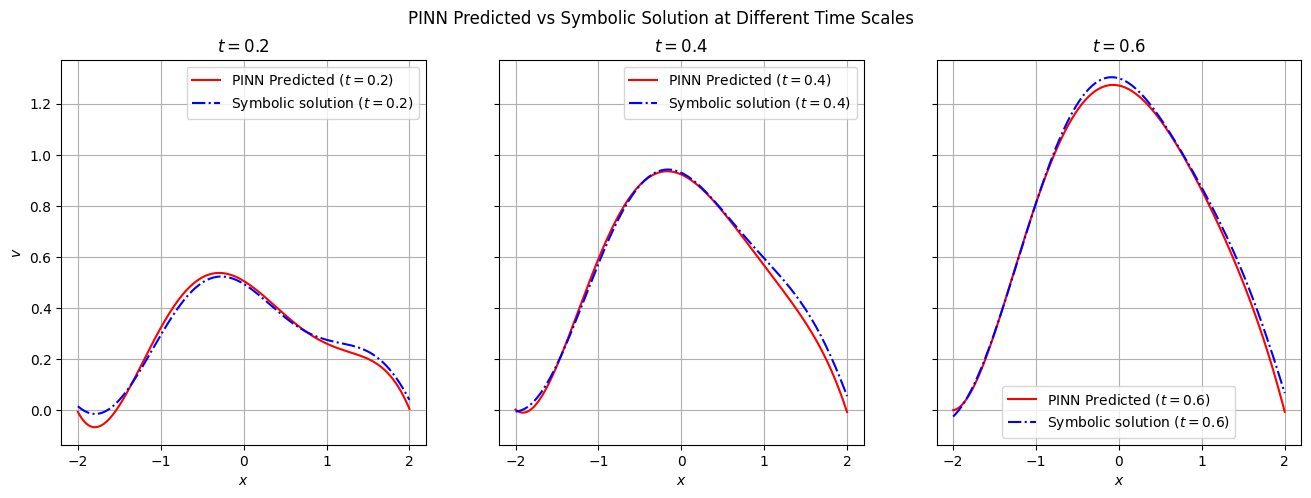

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Parameters for time discretization
T = 1.0    # Total time
N_t = 201  # Number of time steps
delta_t = T / (N_t - 1)

# Define spatial domain (assuming this is given)
#x = np.linspace(-2, 2, 101)  # Example spatial domain

# Example simulated U_pred (assuming a placeholder function)
#U_pred = np.sin(np.pi * x) * np.exp(-0.5 * np.array([t/delta_t for t in range(N_t)])[:, None])

def my_function(x0, x1):
    term1 =(np.cos(0.06555329 - x0) + 0.41444486)*1.6983646*np.sin(np.sin(-(-0.07595206)*x0 + x1 - 0.17622922*(x0 - 1*0.05411254)*np.cos(0.1773623 - x0)))
    term2 = 0
    return (term1)

# Time points of interest
time_points = [0.2, 0.4, 0.6]  # Three time slices

# Compute indices
indices = [round(t / delta_t) for t in time_points]
print("Computed indices:", indices)

# Evaluate the function over the grid
U_SymReg = my_function(xx, tt)

# Create subplots
fig, axes = plt.subplots(1, 3, figsize=(16, 5), sharey=True)

# Colors for predicted and actual solutions
pred_color = 'r'
actual_color = 'b'

# Plot each slice in a separate subplot
for ax, idx, t in zip(axes, indices, time_points):
    ax.plot(x, U_pred[idx, :], pred_color, label=f'PINN Predicted ($t = {t}$)')
    ax.plot(x, U_SymReg[idx, :], actual_color, linestyle='-.', label=f'Symbolic solution ($t = {t}$)')
    ax.set_xlabel('$x$')
    ax.set_title(f'$t = {t}$')
    ax.grid()
    ax.legend()

# Global figure settings
axes[0].set_ylabel('$v$')  # Set only on the first subplot for clarity
fig.suptitle("PINN Predicted vs Symbolic Solution at Different Time Scales", fontsize=12)

# Save and show the figure
plt.savefig('w_slice_comparison.eps', dpi=300, bbox_inches='tight')
plt.show()


In [ ]:
print("Mean residual error of Symbolic Regression model is: ", np.mean(np.absolute(U_SymReg)))
print("Mean absolute error between PINN and Symbolic solution:", np.mean(np.absolute(U_pred-U_SymReg)))
print("Percentage error= ",(np.mean(np.absolute(U_pred-U_SymReg)))*100)

Mean residual error of Symbolic Regression model is:  0.625803020773929
Mean absolute error between PINN and Symbolic solution: 0.02235314410939966
Percentage error=  2.2353144109399663
